# CityJSON Walkthrough

**The purpose of this notebook is to prevent an excessive burden on the [OpenStreetMap](https://www.openstreetmap.org/about) server when [osm_LoD1_3DCityModel](https://github.com/AdrianKriger/osm_LoD1_3DCityModel/tree/main/village_campus) fails; and an investigation into *where* the challenge lies is needed.**

It saves the `overpass`.geojson to prevent calling OSM after every failure. Peruse `pv.Plotter` (cell xxx) at you leisure. 

In [1]:
import os
from itertools import chain

import requests
import overpass
import osm2geojson

import numpy as np
import pandas as pd
import geopandas as gpd

import shapely
import shapely.geometry as sg
from shapely.geometry import Point, LineString, Polygon, shape, mapping
from shapely.ops import snap
from shapely.ops import transform

import fiona
import copy
import json
import geojson

import pyproj

from openlocationcode import openlocationcode as olc

from cjio import cityjson

from osgeo import gdal, ogr

import pyvista as pv
import triangle as tr

import matplotlib.pyplot as plt

In [217]:
import time
from datetime import timedelta

**A `paramater.json` defines the path and files**.

In [218]:
jparams = json.load(open('osm3Dtest_param.json'))

**First get everything via `overpass`**

In [7]:
#buildings
query = """
    [out:json][timeout:25];
    (area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all buildings ~ with levels tagged
        way['building'](area.a);
        // and relation type=multipolygon ~ to removed courtyards from buildings
        relation['building']["type"="multipolygon"](area.a);
    );
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
    #rr = r.read()
gj = osm2geojson.json2geojson(r.json())
#shapes_with_props = osm2geojson.json2shapes(r.json())
#-- store the data as GeoJSON
with open(jparams['ori-gjson_out'], 'w') as outfile:                   
    json.dump(gj, outfile)

In [8]:
#project blds 
ds = gdal.VectorTranslate(jparams['gjson-proj_out'], jparams['ori-gjson_out'], 
                          format = 'GeoJSON', reproject = True, # makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
# de-reference and close dataset
del ds

In [9]:
#aoi
query = """
    [out:json][timeout:30];
    // main area
    area[name='{0}']->.a;
    //gather results
    (
    // focus
    {1}['name'='{2}'](area.a);
    );
    //print results
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
r = requests.get(url, params={'data': query})
area = osm2geojson.json2geojson(r.json())
#area = osm2geojson.json2shapes(r.json())
#-- store the data as GeoJSON
with open(jparams['aoi'], 'w') as outfile:                  
    json.dump(area, outfile)

In [219]:
#project aoi 
ds = gdal.VectorTranslate(jparams['aoi_prj'], jparams['aoi'], 
                          format = 'GeoJSON', reproject = True, makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
# de-reference and close dataset
del ds

In [11]:
#streets
query = """
    [out:json][timeout:25];
    (area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all roads
        way["highway"][highway!~"^(footway|path)$"](area.a);
    );
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
rd = requests.get(url, params={'data': query})
    #rr = r.read()
gj_rd = osm2geojson.json2geojson(rd.json())
#rds = osm2geojson.json2shapes(rd.json())
#-- store the data as GeoJSON
with open(jparams['gjson-rd'], 'w') as outfile:                
    json.dump(gj_rd, outfile)

In [12]:
#project streets 
ds = gdal.VectorTranslate(jparams['gjson_proj-rd'], jparams['gjson-rd'], 
                          format = 'GeoJSON', reproject = True, makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
# de-reference and close dataset
del ds

In [13]:
#parking entrance ~~ just in case
query = """
    [out:json][timeout:25];
    (area[name='{0}'] ->.b;
    // -- target area ~ can be way or relation
    {1}(area.b)[name='{2}'];
    map_to_area -> .a;
        // I want all roads
        node["amenity"="parking_entrance"](area.a);
    );
    out body;
    >;
    out skel qt;
    """.format(jparams['LargeArea'], jparams['osm_type'], jparams['FocusArea'])
    
url = "http://overpass-api.de/api/interpreter"
pk = requests.get(url, params={'data': query})
    #rr = r.read()
gj_pk = osm2geojson.json2geojson(pk.json())
#gj_pk = osm2geojson.json2shapes(pk.json())
#-- store the data as GeoJSON
with open(jparams['gjson-pk'], 'w') as outfile:                   
    json.dump(gj_pk, outfile) 

In [14]:
#project parking 
ds = gdal.VectorTranslate(jparams['gjson_proj-pk'], jparams['gjson-pk'], 
                          format = 'GeoJSON', reproject = True, makeValid=True,
                          srcSRS='EPSG:4326', dstSRS=jparams['crs'])
# de-reference and close dataset
del ds

**Now we process.**  

**If you change the *geometry, shape or alignment* of a building / street in an [OSM editor](https://wiki.openstreetmap.org/wiki/Editors); call / retrieve only what you need; and continue.**

**<span style="color:orange">While *local* updates should reflect immediately;</span> <span style="color:black">GIVE IT A DAY.</span> <span style="color:orange">We are one part of a global community who share [OSM](https://www.openstreetmap.org/about). Consideration will go a long way towards ensuring the longevity of this resource.</span> <span style="color:black"> Please be patient.</span>**

In [220]:
#process aoi 
aoi = gpd.read_file(jparams['aoi_prj'])                   
aoi.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)            
aoi.head(2)

,type,id,tags,geometry
0,way,61135217,"{'amenity': 'university', 'is_in': 'Bellville,...","POLYGON ((281485.937 6243170.380, 281624.930 6..."


In [221]:
if jparams['osm_type'] == 'relation' and len(aoi) > 1:
    for i, row in aoi.iterrows():
        if row.tags != None and 'place' in row.tags:
            focus = row
            
    trim = pd.DataFrame(focus)
    trim = trim.T
    aoi = gpd.GeoDataFrame(trim, geometry = trim['geometry'])
    aoi = aoi.set_crs(jparams['crs'])

In [222]:
aoibuffer = aoi.copy()

def buffer01(row):
    return row.geometry.buffer(150, 
                               cap_style=3, join_style=2)

aoibuffer['geometry'] = aoibuffer.apply(buffer01, axis=1)
    
extent = [aoibuffer.total_bounds[0] - 250, aoibuffer.total_bounds[1] - 250, 
          aoibuffer.total_bounds[2] + 250, aoibuffer.total_bounds[3] + 250]

**Now the DEM**

In [223]:
OutTile = gdal.Warp(jparams['projClip_raster'], 
                    jparams['in_raster'], 
                    dstSRS=jparams['crs'],
                    srcNodata = jparams['nodata'],
                    #dstNodata = 0,
                         #-- outputBounds=[minX, minY, maxX, maxY]
                    outputBounds = [extent[0], extent[1], extent[2], extent[3]])
OutTile = None 

In [224]:
xyz = gdal.Translate(jparams['xyz'], 
                     jparams['projClip_raster'],
                     format = 'XYZ')#, 
                     #noData = float(0))
xyz = None

**Buildings**

In [225]:
ts = gpd.read_file(jparams['gjson-proj_out'])
#ts.drop(ts.index[ts['type'] == 'node'], inplace = True)
#ts['id'] = ts['properties'].apply(lambda x: x.get('id'))
ts['bld'] = ts['tags'].apply(lambda x: x.get('building'))
ts.drop(ts.index[ts['type'] == 'node'], inplace = True)
SKwalk = ts[ts['bld'] == 'bridge'].copy()
roof = ts[ts['bld'] == 'roof'].copy()
ts.drop(ts.index[ts['bld'] == 'bridge'], inplace = True)
ts.drop(ts.index[ts['bld'] == 'roof'], inplace = True)
ts.head(1)

,type,id,tags,geometry,bld
0,way,61135217,"{'amenity': 'university', 'is_in': 'Bellville,...","POLYGON ((281485.937 6243170.380, 281624.930 6...",None


In [226]:
#ts.bld.unique

In [227]:
src_filename = jparams['projClip_raster']

src_ds = gdal.Open(src_filename) 
gt_forward = src_ds.GetGeoTransform()
#gt_reverse = gdal.InvGeoTransform(gt_forward)
rb = src_ds.GetRasterBand(1)

def rasterQuery(geom, gt_forward, rb):

    mx = geom.representative_point().x
    my = geom.representative_point().y
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)
 
    return intval[0][0]

In [228]:
ts['mean'] = ts.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)

In [229]:
ts.head(2)#geometry.type.unique()

,type,id,tags,geometry,bld,mean
0,way,61135217,"{'amenity': 'university', 'is_in': 'Bellville,...","POLYGON ((281485.937 6243170.380, 281624.930 6...",None,62.980000
1,way,897473388,"{'addr:city': 'Cape Town', 'addr:housename': '...","POLYGON ((282031.194 6242903.636, 282029.750 6...",university,63.150002


In [230]:
for i, row in ts.iterrows():
    if row.geometry.type == 'LineString' and len(row.geometry.coords) < 3:
        #print(row)
        ts = ts.drop(ts.index[i])

In [231]:
storeyheight = 2.8
#-- iterate through the list of buildings and create GeoJSON features rich in attributes
footprints = {
    "type": "FeatureCollection",
    "features": []
}
for i, row in ts.iterrows():
    f = {
    "type" : "Feature"
    }
    # at a minimum we only want building:levels tagged
    if row['type'] != 'node' and row['tags'] != None and 'building:levels' in row['tags']:
        
        f["properties"] = {}
            
        #-- store all OSM attributes and prefix them with osm_ 
        f["properties"]["osm_id"] = row.id
        for p in row.tags:
            adr = []
            #-- transform the OSM address to string prefix with osm_
            if 'addr:flats'in row.tags:
                adr.append(row.tags['addr:flats'])
            if 'addr:housenumber'in row.tags:
                adr.append(row.tags['addr:housenumber'])
            if 'addr:housename'in row.tags:
                adr.append(row.tags['addr:housename'])
            if 'addr:street' in row.tags:
                adr.append(row.tags['addr:street'])
            if 'addr:suburb' in row.tags:
                adr.append(row.tags['addr:suburb'])
            if 'addr:postcode' in row.tags:
                adr.append(row.tags['addr:postcode'])
            if 'addr:city' in row.tags:
                adr.append(row.tags['addr:city'])
            if 'addr:province' in row.tags:
                adr.append(row.tags['addr:province'])
            #-- store other OSM attributes and prefix them with osm_
            f["properties"]["osm_%s" % p] = row.tags[p]
                
        f["properties"]["osm_address"] = " ".join(adr)
            
        osm_shape = shape(row["geometry"])
        #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
        #-- rare, but if not done it breaks the code later
        if osm_shape.type == 'LineString':
            osm_shape = Polygon(osm_shape)
        #-- and multipolygons must be accounted for
        elif osm_shape.type == 'MultiPolygon':
            #osm_shape = Polygon(osm_shape[0])
            for poly in osm_shape:
                osm_shape = Polygon(poly)#[0])
                #-- convert the shapely object to geojson
            
        wgs84 = pyproj.CRS('EPSG:4326')
        utm = pyproj.CRS(jparams['crs'])                                   
        p = osm_shape.representative_point()
        project = pyproj.Transformer.from_crs(utm, wgs84, always_xy=True).transform
        wgs_point = transform(project, p)
        f["properties"]["plus_code"] = olc.encode(wgs_point.y, wgs_point.x, 11)
                
        f["geometry"] = mapping(osm_shape)
            
        f["properties"]['ground_height'] = round(row["mean"], 2)
        f["properties"]['building_height'] = round(float(row.tags['building:levels']) * storeyheight + 1.3, 2) 
        f["properties"]['roof_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
        footprints['features'].append(f)
            
for value in footprints['features']:
    if 'osm_addr:flats' in value["properties"]:
        del value["properties"]["osm_addr:flats"]
    if 'osm_addr:housenumber' in value["properties"]:
        del value["properties"]["osm_addr:housenumber"]
    if 'osm_addr:housename' in value["properties"]:
        del value["properties"]["osm_addr:housename"]
    if 'osm_addr:street' in value["properties"]:
        del value["properties"]["osm_addr:street"]
    if 'osm_addr:suburb' in value["properties"]:
        del value["properties"]["osm_addr:suburb"]
    if 'osm_addr:postcode' in value["properties"]:
        del value["properties"]["osm_addr:postcode"]
    if 'osm_addr:city' in value["properties"]:
        del value["properties"]["osm_addr:city"]
    if 'osm_addr:province' in value["properties"]:
        del value["properties"]["osm_addr:province"]

In [232]:
#-- store the data as GeoJSON
with open(jparams['osm_bldings'], 'w') as outfile:        
    json.dump(footprints, outfile)

In [233]:
start = time.time()

dis = gpd.read_file(jparams['osm_bldings'])                       
dis.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)

##-- while this takes a bit of time for larger datasets I include it because of the scale and precision
##-- we are working at
# remove duplicate vertices within tolerance 0.2 
for index, row in dis.iterrows():
    tmp_gdf = dis.copy()
    tmp_gdf['distance'] = tmp_gdf.distance(row['geometry'])
    closest_geom = list(tmp_gdf.sort_values('distance')['geometry'])[1]
        # I took 1 because index 0 would be the row itself
    snapped_geom = snap(row['geometry'], closest_geom, 0.2)
    dis.loc[index, 'geometry'] = snapped_geom

# create a point representing the hole within each building  
dis['x'] = dis.representative_point().x
dis['y'] = dis.representative_point().y
hs = dis[['x', 'y', 'ground_height']].copy()
print(len(dis))

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

69
runtime: 0:00:01.116865


**Streets**

In [234]:
rd = gpd.read_file(jparams['gjson_proj-rd'])
rd.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)
rd.drop(rd.index[rd['type'] == 'node'], inplace = True)

In [235]:
def calc_width(row):
    if np.isnan(row['width']):
    #if row['width'] == np.nan:
        """if nan, calculate the width based on lanes"""
        return row['lanes'] * 2.2
    else:
        return row['width']

#rd.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)
rd['lanes'] = rd['tags'].apply(lambda x: x.get('lanes'))
rd['width'] = rd['tags'].apply(lambda x: x.get('width'))
print(len(rd))

120


In [236]:
rd.dropna(subset=['tags'], inplace=True)
rd['bridge'] = rd['tags'].apply(lambda x: x.get('bridge'))
rd['bridge_structure'] = rd['tags'].apply(lambda x: x.get('bridge:structure'))
rd['tunnel'] = rd['tags'].apply(lambda x: x.get('tunnel'))
rd['name'] = rd['tags'].apply(lambda x: x.get('name'))# if pd.isnull(fillna(np.nan)))

rd['ref'] = rd['tags'].apply(lambda x: x.get('ref'))
rd['destination'] = rd['tags'].apply(lambda x: x.get('destination'))

rd['highway'] = rd['tags'].apply(lambda x: x.get('highway'))
rd['surface'] = rd['tags'].apply(lambda x: x.get('surface'))
rd['oneway'] = rd['tags'].apply(lambda x: x.get('oneway'))

tunnel =  rd[rd['tunnel'].isin(['yes', 'building_passage', 'avalanche_protector'])]
print(len(rd))
rd = rd[rd['geometry'].type != 'Polygon']#) & (rd['lanes'] != np.nan)]

rd['lanes'] = pd.to_numeric(rd['lanes'])
rd['lanes'] = rd['lanes'].fillna(0)
rd['width'] = pd.to_numeric(rd['width'])
rd['width'] = rd.apply(calc_width, axis=1)

bridge = rd[rd['bridge'] == 'yes'].copy()
rd = rd[rd['width'] != 0]
print(len(rd))

120
82


In [237]:
#- buffer_func
def ownbuffer(row):
    return row.geometry.buffer(round(float(row['width']) / 2, 2), cap_style=1)
def ownbuffer02(row):
    return row.geometry.buffer(round(float(row['width']) / 2, 2), cap_style=2)
def ownbuffer03(row):
    return row.geometry.buffer(round(float(row['width']) + 0.25 / 2, 2), cap_style=2)

In [238]:
#bridge_b = bridge.copy()
bridge_b02 = bridge.copy()
#bridge_b['geometry'] = bridge_b.apply(ownbuffer02, axis=1)
bridge_b02['geometry'] = bridge_b02.apply(ownbuffer03, axis=1)
bridge_b02 = bridge_b02.dissolve()#as_index=False, dropna=False)
#bridge_b.head(2)

In [239]:
#https://gis.stackexchange.com/questions/286055/densify-shapely-polygon-using-ogr-segmentize
from shapely.wkt import loads

def segmentize(geom):
    wkt = geom.wkt  # shapely Polygon to wkt
    geom = ogr.CreateGeometryFromWkt(wkt)  # create ogr geometry
    geom.Segmentize(5)                                                     # densify geometry
    wkt2 = geom.ExportToWkt()  # ogr geometry to wkt
    new = loads(wkt2)  # wkt to shapely Polygon
    return new

rd['geometry'] = rd['geometry'].apply(segmentize)

In [240]:
rd.head(2)

,type,id,tags,geometry,lanes,width,bridge,bridge_structure,tunnel,name,ref,destination,highway,surface,oneway
0,way,34953479,"{'access': 'private', 'highway': 'service', 'i...","LINESTRING (282025.712 6242798.110, 282029.830...",2.0,4.4,None,None,None,Engineering Way,None,None,service,asphalt,None
1,way,34953670,"{'access': 'private', 'highway': 'service', 'i...","LINESTRING (281935.657 6242783.921, 281936.328...",2.0,4.4,None,None,None,Science Way,None,None,service,asphalt,None


In [241]:
print(rd.width.unique())
print(rd.lanes.unique())

[4.4 2.2]
[2. 1.]


In [242]:
#https://gis.stackexchange.com/questions/137909/intersecting-lines-to-get-crossings-using-python-with-qgis
import itertools
inters = []
for line1, line2 in itertools.combinations(rd.geometry, 2):
    if line1.intersects(line2):
        inter = line1.intersection(line2)
        if "Point" == inter.type:
            inters.append(inter)
        elif "MultiPoint" == inter.type:
            inters.extend([pt for pt in inter])
        elif "MultiLineString" == inter.type:
            multiLine = [line for line in inter]
            first_coords = multiLine[0].coords[0]
            last_coords = multiLine[len(multiLine)-1].coords[1]
            inters.append(Point(first_coords[0], first_coords[1]))
            inters.append(Point(last_coords[0], last_coords[1]))
        elif "GeometryCollection" == inter.type:
            for geom in inter:
                if "Point" == geom.type:
                    inters.append(geom)
                elif "MultiPoint" == geom.type:
                    inters.extend([pt for pt in geom])
                elif "MultiLineString" == geom.type:
                    multiLine = [line for line in geom]
                    first_coords = multiLine[0].coords[0]
                    last_coords = multiLine[len(multiLine)-1].coords[1]
                    inters.append(Point(first_coords[0], first_coords[1]))
                    inters.append(Point(last_coords[0], last_coords[1]))
                    
pnts = gpd.GeoDataFrame(crs=jparams['crs'], geometry=inters)                      
p_buffer = pnts.buffer(2)
p_buffer = gpd.GeoDataFrame(crs=jparams['crs'], geometry=p_buffer)                 

In [243]:
rd_e = gpd.overlay(rd, p_buffer, how='difference')
rd_e = rd_e.explode()
rd_e.reset_index(drop=True, inplace=True)

In [244]:
rd.head(2)

,type,id,tags,geometry,lanes,width,bridge,bridge_structure,tunnel,name,ref,destination,highway,surface,oneway
0,way,34953479,"{'access': 'private', 'highway': 'service', 'i...","LINESTRING (282025.712 6242798.110, 282029.830...",2.0,4.4,None,None,None,Engineering Way,None,None,service,asphalt,None
1,way,34953670,"{'access': 'private', 'highway': 'service', 'i...","LINESTRING (281935.657 6242783.921, 281936.328...",2.0,4.4,None,None,None,Science Way,None,None,service,asphalt,None


In [245]:
pt = [line.__geo_interface__['coordinates'] for line in rd_e.geometry]
pt_array = np.array(np.concatenate(pt))
#pt_array

In [246]:
po = [i for i in aoibuffer.geometry]
x,y = po[0].exterior.coords.xy
po = np.dstack((x,y))
po_array = np.array(np.concatenate(po))

pt_array = np.concatenate((pt_array, po_array), axis=0)

In [247]:
from scipy.spatial import Voronoi#, voronoi_plot_2d, Delaunay

vor = Voronoi(pt_array)
lines = [shapely.geometry.LineString(vor.vertices[line]) for line in vor.ridge_vertices if -1 not in line]
polys = shapely.ops.polygonize(lines)

vo = gpd.GeoDataFrame(geometry=gpd.GeoSeries(polys), crs=jparams['crs'])    #set the crs

In [248]:
#fig = voronoi_plot_2d(vor)
#plt.show()

In [249]:
join = gpd.sjoin(vo, rd_e, how="left", op="intersects")
#join.head(2)

In [251]:
#print(rd.geometry.type.unique())

In [252]:
t_buffer = tunnel.buffer(1.5, cap_style=2)
t_buffer = gpd.GeoDataFrame(crs=jparams['crs'], geometry=t_buffer)         # set the crs

**Parking entrance ~~ *just in case***

In [253]:
pk = gpd.read_file(jparams['gjson_proj-pk'])                    # set the path
pk.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)
pk.head(1)

,type,id,tags,geometry
0,node,9642552565,"{'access': 'private', 'amenity': 'parking_entr...",POINT (281875.526 6242910.066)


In [254]:
pk = pk[pk['geometry'].type == 'Point']
pk.dropna(subset=['tags'], inplace=True)
pk['entrance'] = pk['tags'].apply(lambda x: x.get('amenity'))
pk =  pk[pk['entrance'].isin(['parking_entrance'])]
#pk.head(1)

In [255]:
#print(rd.geometry.type.unique())

In [256]:
pk_buffer = pk.buffer(2.4, cap_style=3)
pk_buffer = pk_buffer.geometry.rotate(45)                                 # why rotate? strange
pk_buffer = gpd.GeoDataFrame(crs=jparams['crs'], geometry=pk_buffer)        # set the path
#pk_buffer = pk_buffer.geometry.rotate(45)
#pk_buffer.head(2)

In [257]:
rd_b = rd.copy()
rd_b['geometry'] = rd_b.apply(ownbuffer, axis=1)
rd_b = rd_b.dissolve()#as_index=False, dropna=False)

rd_b = rd_b.explode()
rd_b = gpd.overlay(rd_b, t_buffer, how='difference')
rd_b = rd_b.explode()
rd_b = gpd.overlay(rd_b, bridge_b02, how='difference')
rd_b = rd_b.explode()

In [258]:
#print(rd_b.geometry.type.unique())

In [259]:
rd_b = gpd.clip(rd_b, aoi)

one = gpd.clip(join, rd_b)
one.set_crs(epsg=int(jparams['crs'][-5:]), inplace=True, allow_override=True)
one.head(1)

,geometry,index_right,type,id,tags,lanes,width,bridge,bridge_structure,tunnel,name,ref,destination,highway,surface,oneway
589,"POLYGON ((282279.592 6242603.395, 282280.687 6...",54.0,way,795692831.0,"{'access': 'private', 'highway': 'service', 'l...",1.0,2.2,None,None,None,None,None,None,service,concrete,None


In [260]:
print(len(one))#.head(2)
#rd_copy.head(2)
one.drop(one.index[one['bridge'] == 'yes'], inplace = True)
one.drop(one.index[one['tunnel'].isin(['yes', 'building_passage', 'avalanche_protector'])], inplace = True) #rd[rd['tunnel'].isin(['yes', 'building_passage'])]
one = one.dissolve(by=['name', 'highway', 'surface', 'oneway', 'lanes', 'ref', 'destination'], 
                   as_index=False, dropna=False)
#one.reset_index(drop=True, inplace=True)
print(one.geometry.type.unique())
one = one.explode()
one.reset_index(drop=True, inplace=True)

1707
['Polygon' 'MultiPolygon']


In [261]:
one.tail(3)

,name,highway,surface,oneway,lanes,ref,destination,index_right,type,id,tags,width,bridge,bridge_structure,tunnel,geometry
55,NaN,unclassified,asphalt,NaN,2.0,NaN,NaN,14.0,way,61133431.0,"{'highway': 'unclassified', 'is_in': 'Bellvill...",4.4,None,None,None,"POLYGON ((281551.166 6243209.042, 281548.816 6..."
56,NaN,unclassified,asphalt,NaN,2.0,NaN,NaN,14.0,way,61133431.0,"{'highway': 'unclassified', 'is_in': 'Bellvill...",4.4,None,None,None,"POLYGON ((281483.248 6243214.585, 281483.180 6..."
57,NaN,unclassified,ground,NaN,1.0,NaN,NaN,84.0,way,968448030.0,"{'access': 'private', 'highway': 'unclassified...",2.2,None,None,None,"POLYGON ((282346.364 6242805.405, 282344.307 6..."


In [262]:
one.dropna(subset=['geometry'], inplace=True)
#one = one[~(one['geometry'].is_empty | one['geometry'].isna())]
#one = one[one['geometry'].type != 'GeometryCollection']#) & (rd['lanes'] != np.nan)]
one.loc[one["id"].isnull(), "id"] = (one["id"].isnull().cumsum()).astype(float) #"Other" + 
one.loc[one["tags"].isnull(), "tags"] = [{'processing': 'ExtraFeature'}]
#one['tags'].apply(lambda x: x if x is not None else [{'processing': 'ExtraFeature'}])
one.reset_index(drop=True, inplace=True)
print(one.geometry.type.unique())

['Polygon']


In [263]:
def rasterQuery2(mx, my, gt_forward, rb):
    
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])

    intval = rb.ReadAsArray(px, py, 1, 1)

    return intval[0][0]

In [264]:
#union = one.dissolve()
one['x'] = one.geometry.representative_point().x
one['y'] = one.geometry.representative_point().y
one['ground_height'] = one.apply(lambda row: rasterQuery2(row.x, row.y, gt_forward, rb), axis = 1)

In [265]:
#one.head(2)
print(one.name.unique())

['Achievers Way' 'Business Way' 'Design Way' 'Education Way'
 'Engineering Way' 'Mabaleng Way' 'Mechanical Way' 'Recreation Way'
 'Science Way' 'Technology Way' nan]


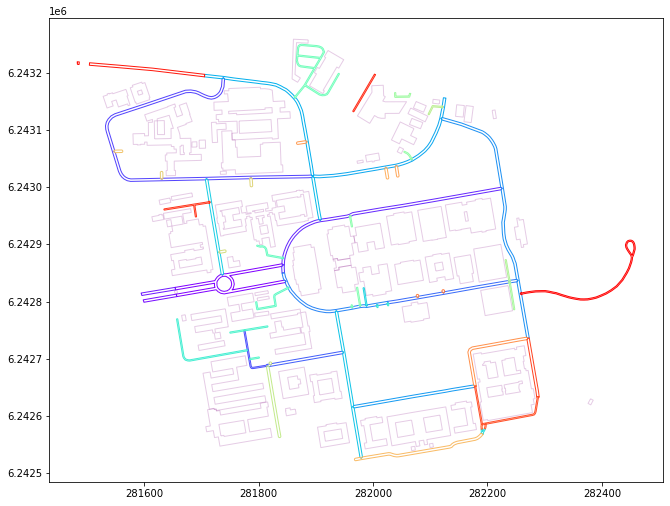

In [266]:
fig, ax = plt.subplots(figsize=(11, 11))
#ax.margins(-0.2, -0.2)

#rd.plot(ax=ax, facecolor='none', edgecolor='blue')
dis.plot(ax=ax, facecolor='none', edgecolor='purple', alpha=0.2)
one.plot(ax=ax, cmap='rainbow', facecolor='none')#, edgecolor='green')
#plt.ylim([6243200, 6243250])
#plt.xlim([281400, 281600])

#ax.scatter(one['x'], one['y'], c='r')

plt.show()

In [214]:
#one.tail(2)

In [267]:
#https://stackoverflow.com/questions/50916422/python-typeerror-object-of-type-int64-is-not-json-serializable
#def np_encoder(object):
    #if isinstance(object, np.generic):
        #return object.item()
    
count = 1000000

roads = {
    "type": "FeatureCollection",
    "features": []
}
for i, row in one.iterrows():
    f = {
    "type" : "Feature"
    }
    f["properties"] = {}
    #for p in i["properties"]:
            #-- store all OSM attributes and prefix them with osm_ 
    f["properties"]["id"] = count
    f["properties"]["osm_id"] = row.id
    if row['type'] != 'node':# and row['tags'] != None:
        #print(i)
        for p in row.tags:
            f["properties"]["osm_%s" % p] = row.tags[p]

    roads['features'].append(f)
    count += 1
    #break

In [268]:
#-- store the data as GeoJSON
with open(jparams['gjson_rd_out'], 'w') as outfile:                # set the path
    json.dump(roads, outfile)#, default=np_encoder)

**Now we get into the *real stuff***

In [269]:
#the holes that need to be removed from the terrain
hsr = one[['x', 'y', 'ground_height']].copy()
Allhs = hs.append(hsr)

In [270]:
#prepare for and symmetric_difference the aoi/buildings_streets
dis_c = dis.copy()
dis_c = dis_c.append(one)

In [271]:
start = time.time()

df = pd.read_csv(jparams['xyz'],                                       # set the path
                 delimiter = ' ', header=None, names=["x", "y", "z"])
    
geometry = [Point(xy) for xy in zip(df.x, df.y)]
gdf = gpd.GeoDataFrame(df, crs=jparams['crs'], geometry=geometry)                    # set the crs
    
_symdiff = gpd.overlay(aoibuffer, dis_c, keep_geom_type=False, how='symmetric_difference') 
_mask = gdf.within(_symdiff.loc[0, 'geometry'])
gdf = gdf.loc[_mask]
gdf = gdf[gdf['z'] != jparams['nodata']]                               # set the correct nodata value
gdf.reset_index(drop=True, inplace=True)
gdf = gdf.round(2)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:21.498757


In [272]:
#_symdiff.plot()

**segments**

In [273]:
#blds
all_coords = []
dps = 2
segs = {}
geoms = {}
    
for ids, row in dis.iterrows():
    oring, z = list(row.geometry.exterior.coords), row['ground_height']
    rounded_z = round(z, dps)
    coords_rounded = []
        #po = []
    for x, y in oring:
        rounded_x = round(x, dps)
        rounded_y = round(y, dps)
        coords_rounded.append((rounded_x, rounded_y, rounded_z))
        all_coords.append([rounded_x, rounded_y, rounded_z])

    for i in range(0, len(coords_rounded)-1):
        x1, y1, z1 = coords_rounded[i]
        x2, y2, z2 = coords_rounded[i+1]
                    # deduplicate lines which overlap but go in different directions
        if (x1 < x2):
            key = (x1, y1, x2, y2)
        else:
            if (x1 == x2):
                if (y1 < y2):
                    key = (x1, y1, x2, y2)
                else:
                    key = (x2, y2, x1, y1)
            else:
                key = (x2, y2, x1, y1)
        if key not in segs:
            segs[key] = 1
        else:
            segs[key] += 1
    ##-- if polygon has interior (ground in couryard)                
    for interior in row.geometry.interiors:
        oring, z = list(interior.coords), row['ground_height']
        rounded_z = round(z, dps)
        coords_rounded = []
            #po = []
        for x, y in oring:
            rounded_x = round(x, dps)
            rounded_y = round(y, dps)
            coords_rounded.append((rounded_x, rounded_y, rounded_z))
            all_coords.append([rounded_x, rounded_y, rounded_z])

        for i in range(0, len(coords_rounded)-1):
            x1, y1, z1 = coords_rounded[i]
            x2, y2, z2 = coords_rounded[i+1]
                        # deduplicate lines which overlap but go in different directions
            if (x1 < x2):
                key = (x1, y1, x2, y2)
            else:
                if (x1 == x2):
                    if (y1 < y2):
                        key = (x1, y1, x2, y2)
                    else:
                        key = (x2, y2, x1, y1)
                else:
                    key = (x2, y2, x1, y1)
            if key not in segs:
                segs[key] = 1
            else:
                segs[key] += 1
    
c = pd.DataFrame.from_dict(segs, orient="index").reset_index()
c.rename(columns={'index':'coords'}, inplace=True)
    
ac = pd.DataFrame(all_coords, columns=['x', 'y', 'z'])
ac = ac.sort_values(by = 'z', ascending=False)
ac.drop_duplicates(subset=['x','y'], keep= 'first', inplace=True)
ac = ac.reset_index(drop=True)

In [274]:
df2 = gdf.append(ac, ignore_index=True)

In [275]:
print(len(df2))

2918


In [276]:
idx = []
l = len(gdf) #- 1
    
for i, row in c.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (ac[(ac['x'] == frx) & (ac['y'] == fry)].index.values)
    [index_t] = (ac[(ac['x'] == tox) & (ac['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])
print(len(idx))

1220


In [277]:
#aoi
aoi_coords = []
dps = 2
segs = {}
    
for ids, row in aoibuffer.iterrows():
    oring = list(row.geometry.exterior.coords)
    coords_rounded = []
    po = []
    for x, y in oring:
        z = rasterQuery2(x, y, gt_forward, rb)
                
        rounded_x = round(float(x), dps)
        rounded_y = round(float(y), dps)
        rounded_z = round(float(z), dps)
        coords_rounded.append((rounded_x, rounded_y, rounded_z))
        aoi_coords.append([rounded_x, rounded_y, rounded_z])

    for i in range(0, len(coords_rounded)-1):
        x1, y1, z1 = coords_rounded[i]
        x2, y2, z2 = coords_rounded[i+1]
        # deduplicate lines which overlap but go in different directions
        if (x1 < x2):
            key = (x1, y1, x2, y2)
        else:
            if (x1 == x2):
                if (y1 < y2):
                    key = (x1, y1, x2, y2)
                else:
                    key = (x2, y2, x1, y1)
            else:
                key = (x2, y2, x1, y1)
        if key not in segs:
            segs[key] = 1
        else:
            segs[key] += 1
                        
ca = pd.DataFrame.from_dict(segs, orient="index").reset_index()
ca.rename(columns={'index':'coords'}, inplace=True)
    
acoi = pd.DataFrame(aoi_coords, columns=['x', 'y', 'z'])
  
acoi = acoi.sort_values(by = 'z', ascending=False)
acoi.drop_duplicates(subset=['x','y'], keep= 'first', inplace=True)
acoi = acoi.reset_index(drop=True)

In [278]:
l = len(df2) #- 1
#l = len(df3) #- 1
lr = 0
idx01 = []
 
for i, row in ca.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (acoi[(acoi['x'] == frx) & (acoi['y'] == fry)].index.values)
    [index_t] = (acoi[(acoi['x'] == tox) & (acoi['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])
    idx01.append([lr + index_f, lr + index_t])

In [279]:
#df4 = df3.append(acoi, ignore_index=True)
df3 = df2.append(acoi, ignore_index=True)

In [280]:
#streets and triangulate inside every road segment
start = time.time()

r_coords = []
r_coords02 = []
dps = 2
segs = {}
segs02 = {}
#geoms = {}
idx01 = [] #_copy = idx01.copy()
idx02 = []
idxAll = []
acoi_copy = acoi.copy()
#l1 = 0 #len(gdf) #- 1
l02 = len(acoi_copy)  #- 1
#l03 = 0 #-1 #len(gdf) #- 1
arr = [] #np.empty((0,2), int)
Ahsr = pd.DataFrame(columns=['x', 'y', 'ground_height']) #[]
temp_Ahsr = pd.DataFrame(columns=['x', 'y', 'ground_height']) #[]
#pnt_df = pd.DataFrame(columns=['x', 'y', 'z'])
#count_pnt_df = pd.DataFrame(columns=['x', 'y', 'z'])
t_list = []
#t_list02 = []
rd_pts = []
count = 0
#idxAll.append(count)
for ids, row in one.iterrows():
   
    oring = list(row.geometry.exterior.coords)
    coords_rounded = []
    po = []
    for x, y in oring:
        z = rasterQuery2(x, y, gt_forward, rb)

        rounded_x = round(x, dps)
        rounded_y = round(y, dps)
        rounded_z = round(float(z), dps)
        coords_rounded.append((rounded_x, rounded_y, rounded_z))
        r_coords.append([rounded_x, rounded_y, rounded_z])
        r_coords02.append([rounded_x, rounded_y, rounded_z])
        
    for i in range(0, len(coords_rounded)-1):
        x1, y1, z1 = coords_rounded[i]
        x2, y2, z2 = coords_rounded[i+1]
        # deduplicate lines which overlap but go in different directions
        #key = (x1, y1, x2, y2)
        if (x1 < x2):
            key = (x1, y1, x2, y2)
        else:
            if (x1 == x2):
                if (y1 < y2):
                    key = (x1, y1, x2, y2)
                else:
                    key = (x2, y2, x1, y1)
            else:
                key = (x2, y2, x1, y1)
        if key not in segs:
            segs[key] = 1
        else:
            segs[key] += 1
        if key not in segs02:
            segs02[key] = 1
        else:
            segs02[key] += 1
    
    arr01 = hs[['x', 'y']].round(3).values.tolist()
    ##-- if polygon has interior (circular roads with 'islands')   
    g = row.geometry.interiors
    for i, interior in enumerate(g):

        if interior != None:
            x, y = interior.centroid.xy

            arr.append([x[0], y[0], row['ground_height']])
            ho = Ahsr.append(pd.DataFrame(arr, columns=['x', 'y', 'ground_height']))
            temp_Ahsr = hs.append(ho)
            arr = temp_Ahsr[['x', 'y']].round(3).values.tolist()
            #print(arr)

        coords_rounded = []
        for pair in list(interior.coords):
            #coords_rounded = []
            x = pair[0]
            y = pair[1]
            z = rasterQuery2(x, y, gt_forward, rb)
            
            rounded_x = round(x, dps)
            rounded_y = round(y, dps)
            rounded_z = round(float(z), dps)
            coords_rounded.append((rounded_x, rounded_y, rounded_z))
            r_coords.append([rounded_x, rounded_y, rounded_z])
            r_coords02.append([rounded_x, rounded_y, rounded_z])
            
        for i in range(0, len(coords_rounded)-1):
            x1, y1, z1 = coords_rounded[i]
            x2, y2, z2 = coords_rounded[i+1]
            # deduplicate lines which overlap but go in different directions
            #key = (x1, y1, x2, y2)
            if (x1 < x2):
                key = (x1, y1, x2, y2)
            else:
                if (x1 == x2):
                    if (y1 < y2):
                        key = (x1, y1, x2, y2)
                    else:
                        key = (x2, y2, x1, y1)
                else:
                    key = (x2, y2, x1, y1)
            if key not in segs:
                segs[key] = 1
            else:
                segs[key] += 1
            if key not in segs02:
                segs02[key] = 1
            else:
                segs02[key] += 1
                    
    crx = pd.DataFrame.from_dict(segs02, orient="index").reset_index()
    crx.rename(columns={'index':'coords'}, inplace=True)
    
    acrx = pd.DataFrame(r_coords02, columns=['x', 'y', 'z'])
    acrx = acrx.sort_values(by = 'z', ascending=False)
    acrx.drop_duplicates(subset=['x','y'], keep= 'first', inplace=True)
    acrx = acrx.reset_index(drop=True)
    acoi_copy = acoi_copy.append(acrx, ignore_index=True)

    r_pts = acoi_copy[['x', 'y', 'z']].values
    rd_pts.append(r_pts)
    pts = acoi_copy[['x', 'y']].values
    
    for i, row in crx.iterrows():
        frx, fry = row.coords[0], row.coords[1]
        tox, toy = row.coords[2], row.coords[3]
        [index_f] = (acrx[(acrx['x'] == frx) & (acrx['y'] == fry)].index.values)
        [index_t] = (acrx[(acrx['x'] == tox) & (acrx['y'] == toy)].index.values)
        idx01.append([l02 + index_f, l02 + index_t])

    idxAll.append(idx01)
    if len(arr) >= 1:
        A = dict(vertices=pts, segments=idx01, holes=arr)
    else:
        A = dict(vertices=pts, segments=idx01, holes=arr01)
    Tr = tr.triangulate(A, 'pVV')  # the VV will print stats in the cmd
    t = Tr.get('triangles').tolist()
    #tr.plot(plt.axes(), **Tr)
    t_list.append(t)

    arr = [] #np.empty((0,2), int)
    segs02 = {}
    r_coords02 = []
    idx01 = [] #idx01_copy.copy()

    acoi_copy = acoi.copy()
                                
cr = pd.DataFrame.from_dict(segs, orient="index").reset_index()
cr.rename(columns={'index':'coords'}, inplace=True)
    
acr = pd.DataFrame(r_coords, columns=['x', 'y', 'z'])
acr = acr.sort_values(by = 'z', ascending=False)
acr.drop_duplicates(subset=['x','y'], keep= 'first', inplace=True)
acr = acr.reset_index(drop=True)

end = time.time()
print('runtime:', str(timedelta(seconds=(end - start))))

runtime: 0:00:14.956780


In [281]:
#df3 = df2.append(acr, ignore_index=True)
df4 = df3.append(acr, ignore_index=True)

In [282]:
l = len(df3) #- 1
#rdSegs = []
    
for i, row in cr.iterrows():
    frx, fry = row.coords[0], row.coords[1]
    tox, toy = row.coords[2], row.coords[3]

    [index_f] = (acr[(acr['x'] == frx) & (acr['y'] == fry)].index.values)
    [index_t] = (acr[(acr['x'] == tox) & (acr['y'] == toy)].index.values)
    idx.append([l + index_f, l + index_t])
    #rdSegs.append([lr + index_f, lr + index_t])
print(len(idx))

9665


**Triangle**

In [283]:
#pv_pts = df3[['x', 'y', 'z']].values
pv_pts = df4[['x', 'y', 'z']].values

In [284]:
holes01 = Allhs[['x', 'y']].round(3).values.tolist()
#pts = df3[['x', 'y']].values #, 'z']].values
pts = df4[['x', 'y']].values #, 'z']].values

#the terrain without the blds and streets
A = dict(vertices=pts, segments=idx, holes=holes01)
Tr = tr.triangulate(A, 'pVV')  # the VV will print stats in the cmd
terrTin = Tr.get('triangles').tolist()

**Plot**

In [285]:
l = np.vstack(idx)
l = l.reshape([-1, 2])
twos = np.array([[2]] * len(idx))
lines = np.append(twos, l, axis=1)
    
trin = pv.PolyData(pv_pts)
polygon2 = pv.PolyData(pv_pts)
holes = pv.PolyData()
# Make sure it has the same points as the mesh being triangulated
trin.points = pv_pts
holes = Allhs[['x', 'y', 'ground_height']].values

In [286]:
faces = np.insert(terrTin, 0, np.full((1, len(terrTin)), 3), axis=1)
trin.faces = faces
polygon2.lines = lines

## !!Stop!!  

**Its failing here: run with `#p.add_mesh(trin, color="blue", show_edges=True, opacity=0.2)` and check**

In [287]:
p = pv.Plotter(window_size=[750, 450], notebook=False)
p.add_mesh(trin, color="blue", show_edges=True, opacity=0.2)
p.add_mesh(polygon2, color="black", opacity=0.3, render_points_as_spheres=False)
p.add_mesh(holes, color="red")
    
p.set_background('white')
p.show()

|  |  |
|:--------:|:--------:|
|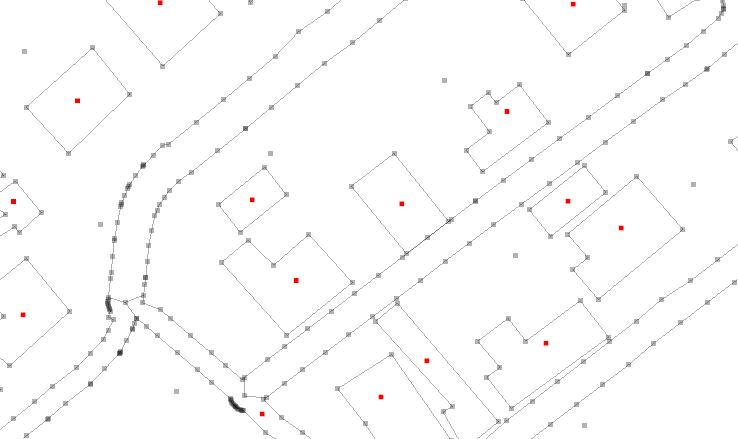 | **It will be more challenging <br /> to find where the problem is**|
|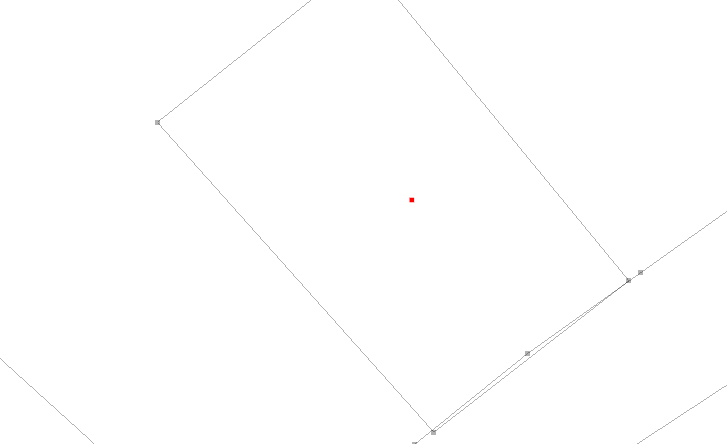 | **Generally where lines cross**|
|<br /> **If you continue the LoD1 City Model *will not be error free*.** | <br /> **Our goal is a topologically correct surface.** |
|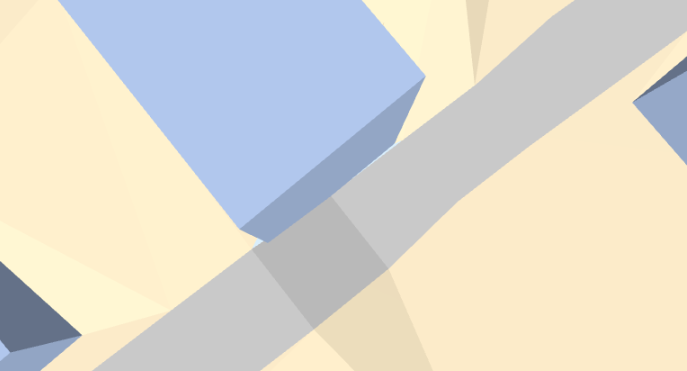| **The model will have holes, gaps <br /> and will *NOT* be watertight<br /> (the slivers of blue on the side of the building) <br /> *---not what we want.* <br /> <br /> Either the alignment of the road must change <br /> *---perhaps the width is incorrect?---* <br /> or the building must move.**|

<h2><center>Please create a topologically correct surface!</center></h2>

**Prepare for CityJSON**

In [289]:
minz = df4['z'].min()
maxz = df4['z'].max()

In [290]:
def rasterQuery(geom, gt_forward, rb):
    mx = geom.representative_point().x
    my = geom.representative_point().y
  
    px = int((mx - gt_forward[0]) / gt_forward[1])
    py = int((my - gt_forward[3]) / gt_forward[5])
    
    intval = rb.ReadAsArray(px, py, 1, 1)
    
    return intval[0][0]

In [291]:
if len(SKwalk) > 0:
    SKwalk['mean'] = SKwalk.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)

In [292]:
#SKwalk

In [293]:
storeyheight = 2.8
#-- iterate through the skywalk features
skywalk = {
    "type": "FeatureCollection",
    "features": []
}
for i, row in SKwalk.iterrows():
    f = {
    "type" : "Feature"
    }
        
    f["properties"] = {}
            
    #-- store all OSM attributes and prefix them with osm_ 
    f["properties"]["osm_id"] = row.id
    for p in row.tags:
        f["properties"]["osm_%s" % p] = row.tags[p]
            
    osm_shape = shape(row["geometry"])
    #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
    #-- rare, but if not done it breaks the code later
    if osm_shape.type == 'LineString':
        osm_shape = Polygon(osm_shape)
    #-- and multipolygons must be accounted for
    elif osm_shape.type == 'MultiPolygon':
        #osm_shape = Polygon(osm_shape[0])
        for poly in osm_shape:
            osm_shape = Polygon(poly)#[0])
            #-- convert the shapely object to geojson
                
    f["geometry"] = mapping(osm_shape)
            
    f["properties"]['ground_height'] = round(row["mean"], 2)
    if row.tags['min_height'] != None:
        f["properties"]['min_height'] = round((float(row.tags['min_height'])) + row["mean"], 2)
    else:
        f["properties"]['min_height'] = round((float(row.tags['building:min_level']) * storeyheight) + row["mean"], 2)
        
    f["properties"]['building_height'] = round(float(row.tags['building:levels']) * storeyheight, 2)
    f["properties"]['max_height'] = round(f["properties"]['building_height'] + row["mean"], 2)
    skywalk['features'].append(f)

In [294]:
print(len(roof))

22


In [295]:
if len(roof) > 0:
    roof['mean'] = roof.apply(lambda row: rasterQuery(row.geometry, gt_forward, rb), axis = 1)

In [296]:
storeyheight = 2.8
#-- iterate through the rooves
_roof = {
    "type": "FeatureCollection",
    "features": []
}
for i, row in roof.iterrows():
    f = {
    "type" : "Feature"
    }
    # at a minimum we only want some tags   
    if row['type'] != 'node' and row['tags'] != None and 'building:levels' in row['tags']:
        
        f["properties"] = {}
            
        #-- store all OSM attributes and prefix them with osm_ 
        f["properties"]["osm_id"] = row.id
        for p in row.tags:
            f["properties"]["osm_%s" % p] = row.tags[p]
            
        osm_shape = shape(row["geometry"])
        #-- a few buildings are not polygons, rather linestrings. This converts them to polygons
        #-- rare, but if not done it breaks the code later
        if osm_shape.type == 'LineString':
            osm_shape = Polygon(osm_shape)
        #-- and multipolygons must be accounted for
        elif osm_shape.type == 'MultiPolygon':
        #osm_shape = Polygon(osm_shape[0])
            for poly in osm_shape:
                osm_shape = Polygon(poly)#[0])
                #-- convert the shapely object to geojson
                
        f["geometry"] = mapping(osm_shape)
            
        f["properties"]['ground_height'] = round(row["mean"], 2)
        f["properties"]['bottom_roof_height'] = round(float(row.tags['building:levels']) * storeyheight + row["mean"], 2) 
        f["properties"]['top_roof_height'] = round(f["properties"]['bottom_roof_height'] + 1.5, 2)
        _roof['features'].append(f)

In [298]:
def doVcBndGeomRd(lsgeom, lsattributes, rdattributes, t_list, rd_pts, extent, minz, maxz, TerrainT, pts, acoi, 
                jparams, skywgeom=None, skywgeomattributes=None,
                roofgeom=None, roofgeomattributes=None): 
    #-- create the JSON data structure for the City Model
    cm = {}
    cm["type"] = "CityJSON"
    cm["version"] = "1.1"
    #cm["transform"] = {
    #    "scale": [0.0, 0.0, 0.0],
    #    "translate": [1.0, 1.0, 1.0]
    #},
    cm["CityObjects"] = {}
    cm["vertices"] = []
    #-- Metadata is added manually
    cm["metadata"] = {
    "title": jparams['cjsn_title'],
    "referenceDate": jparams['cjsn_referenceDate'],
    "referenceSystem": jparams['cjsn_referenceSystem'],
    "geographicalExtent": [
        extent[0],
        extent[1],
        minz ,
        extent[1],
        extent[1],
        maxz
      ],
    "datasetPointOfContact": {
        "contactName": jparams['cjsn_contactName'],
        "emailAddress": jparams['cjsn_emailAddress'],
        "contactType": jparams['cjsn_contactType'],
        "website": jparams['cjsn_website']
        },
    "+metadata-extended": {
        "lineage":
            [{"featureIDs": ["TINRelief"],
             "source": [
                 {
                     "description": jparams['cjsn_+meta-description'],
                     "sourceSpatialResolution": jparams['cjsn_+meta-sourceSpatialResolution'],
                     "sourceReferenceSystem": jparams['cjsn_+meta-sourceReferenceSystem'],
                     "sourceCitation":jparams['cjsn_+meta-sourceCitation'],
                     }],
             "processStep": {
                 "description" : "Processing of raster DEM using osm_LoD1_3DCityModel workflow",
                 "processor": {
                     "contactName": jparams['cjsn_contactName'],
                     "contactType": jparams['cjsn_contactType'],
                     "website": jparams['cjsn_website']
                     }
                 }
            },
            {"featureIDs": ["Building", "Road"],
             "source": [
                 {
                     "description": "OpenStreetMap contributors",
                     "sourceReferenceSystem": "urn:ogc:def:crs:EPSG:4326",
                     "sourceCitation": "https://www.openstreetmap.org",
                 }],
             "processStep": {
                 "description" : "Processing of building vector contributions using osm_LoD1_3DCityModel workflow",
                 "processor": {
                     "contactName": jparams['cjsn_contactName'],
                     "contactType": jparams['cjsn_contactType'],
                     "website": "https://github.com/AdrianKriger/osm_LoD1_3DCityModel"
                     }
                 }
            }]
        }
    }
    ##-- do terrain
    add_terrain_v(pts, cm)
    grd = {}
    grd['type'] = 'TINRelief'
    grd['geometry'] = [] #-- a cityobject can have >1 
     #-- the geometry
    g = {} 
    g['type'] = 'CompositeSurface'
    g['lod'] = 1
    g['boundaries'] = []
    allsurfaces = [] #-- list of surfaces
    add_terrain_b(TerrainT, allsurfaces)
    g['boundaries'] = allsurfaces
    #print(g['boundaries'])
    #g['boundaries'].append(allsurfaces)
      #-- add the geom 
    grd['geometry'].append(g)
      #-- insert the terrain as one new city object
    cm['CityObjects']['terrain01'] = grd
    
    ##-- do roads
    for i, (rp, Rtin) in enumerate(zip(rd_pts, t_list)):
        rp = rp[len(acoi):, :]
        add_rd_v(rp, acoi, cm)
        onerd = {}
        onerd['type'] = 'Road'
        onerd['geometry'] = [] #-- a cityobject can have >1 
          #-- the geometry
        g = {} 
        g['type'] = 'MultiSurface'
        g['lod'] = 1
        g['boundaries'] = []
        allsurfaces = [] #-- list of surfaces
        add_rd_b(Rtin, rp, acoi, allsurfaces, cm)
        #add_rd_b(t_list[count], rp, acoi, allsurfaces, cm)
        onerd['attributes'] = {}
        for k, v in list(rdattributes[i].items()):
            if v is None:
                del rdattributes[i][k]
        for a in rdattributes[i]:
            onerd['attributes'][a] = rdattributes[i][a]
        g['boundaries'] = allsurfaces
        #g['boundaries'].append(allsurfaces)
          #-- add the geom 
        onerd['geometry'].append(g)
        #print(g['boundaries'])
        #onerd['geometry'] = g
          #-- insert one road as one new city object
        cm['CityObjects'][rdattributes[i]['id']] = onerd
        #count = count + 1
        #break
    
     #-- then buildings
    for (i, geom) in enumerate(lsgeom):
        footprint = geom
        #-- one building
        oneb = {}
        oneb['type'] = 'Building'
        oneb['attributes'] = {}
        for k, v in list(lsattributes[i].items()):
            if v is None:
                del lsattributes[i][k]
        for a in lsattributes[i]:
            oneb['attributes'][a] = lsattributes[i][a]
        oneb['geometry'] = [] #-- a cityobject can have > 1
        #-- the geometry
        g = {} 
        g['type'] = 'Solid'
        g['lod'] = 1
        allsurfaces = [] #-- list of surfaces forming the oshell of the solid
        #-- exterior ring of each footprint
        oring = list(footprint.exterior.coords)
        oring.pop() #-- remove last point since first==last
        if footprint.exterior.is_ccw == False:
            #-- to get proper orientation of the normals
            oring.reverse() 
        extrude_walls(oring, lsattributes[i]['roof_height'], lsattributes[i]['ground_height'],
                      allsurfaces, cm)
        #-- interior rings of each footprint
        irings = []
        interiors = list(footprint.interiors)
        for each in interiors:
            iring = list(each.coords)
            iring.pop() #-- remove last point since first==last
            if each.is_ccw == True:
                #-- to get proper orientation of the normals
                iring.reverse() 
            irings.append(iring)
            extrude_walls(iring, lsattributes[i]['roof_height'], lsattributes[i]['ground_height'],
                          allsurfaces, cm)
        #-- top-bottom surfaces
        extrude_roof_ground(oring, irings, lsattributes[i]['roof_height'], 
                            False, allsurfaces, cm)
        extrude_roof_ground(oring, irings, lsattributes[i]['ground_height'], 
                            True, allsurfaces, cm)
        #-- add the extruded geometry to the geometry
        g['boundaries'] = []
        g['boundaries'].append(allsurfaces)
        #g['boundaries'] = allsurfaces
        #-- add the geom to the building 
        oneb['geometry'].append(g)
        #-- insert the building as one new city object
        cm['CityObjects'][lsattributes[i]['osm_id']] = oneb
        
    #-- then sykwalk
    if skywgeom != None:
        for (i, geom) in enumerate(skywgeom):
            skyprint = geom
        #-- one building
            oneb = {}
            oneb['type'] = 'Bridge'
            oneb['attributes'] = {}
            for k, v in list(skywgeomattributes[i].items()):
                if v is None:
                    del skywgeomattributes[i][k]
            for a in skywgeomattributes[i]:
                oneb['attributes'][a] = skywgeomattributes[i][a]
        
            oneb['geometry'] = [] #-- a cityobject can have > 1
             #-- the geometry
            g = {} 
            g['type'] = 'Solid'
            g['lod'] = 1
            allsurfaces = [] #-- list of surfaces forming the oshell of the solid
            #-- exterior ring of each footprint
            oring = list(skyprint.exterior.coords)
            oring.pop() #-- remove last point since first==last
            if skyprint.exterior.is_ccw == False:
                #-- to get proper orientation of the normals
                oring.reverse() 
            extrude_walls(oring, skywgeomattributes[i]['max_height'], skywgeomattributes[i]['min_height'],
                          allsurfaces, cm)
            #-- interior rings of each footprint
            irings = []
            interiors = list(skyprint.interiors)
            for each in interiors:
                iring = list(each.coords)
                iring.pop() #-- remove last point since first==last
                if each.is_ccw == True:
                    #-- to get proper orientation of the normals
                    iring.reverse() 
                irings.append(iring)
                extrude_walls(iring, skywgeomattributes[i]['max_height'], skywgeomattributes[i]['min_height'],
                              allsurfaces, cm)
            #-- top-bottom surfaces
            extrude_roof_ground(oring, irings, skywgeomattributes[i]['max_height'], 
                                False, allsurfaces, cm)
            extrude_roof_ground(oring, irings, skywgeomattributes[i]['min_height'], 
                                True, allsurfaces, cm)
            #-- add the extruded geometry to the geometry
            g['boundaries'] = []
            g['boundaries'].append(allsurfaces)
            #g['boundaries'] = allsurfaces
            #-- add the geom to the building 
            oneb['geometry'].append(g)
            #-- insert the building as one new city object
            cm['CityObjects'][skywgeomattributes[i]['osm_id']] = oneb

    #-- then roof
    if roofgeom != None:
        for (i, geom) in enumerate(roofgeom):
            roofprint = geom
            #-- one building
            oneb = {}
            oneb['type'] = 'Building'
            oneb['attributes'] = {}
            for k, v in list(roofgeomattributes[i].items()):
                if v is None:
                    del roofgeomattributes[i][k]
            for a in roofgeomattributes[i]:
                oneb['attributes'][a] = roofgeomattributes[i][a]
        
            oneb['geometry'] = [] #-- a cityobject can have > 1
            #-- the geometry
            g = {} 
            g['type'] = 'Solid'
            g['lod'] = 1
            allsurfaces = [] #-- list of surfaces forming the oshell of the solid
            #-- exterior ring of each footprint
            oring = list(roofprint.exterior.coords)
            oring.pop() #-- remove last point since first==last
            if roofprint.exterior.is_ccw == False:
                #-- to get proper orientation of the normals
                oring.reverse() 
            extrude_walls(oring, roofgeomattributes[i]['top_roof_height'], 
                          roofgeomattributes[i]['bottom_roof_height'],
                          allsurfaces, cm)
            #-- interior rings of each footprint
            irings = []
            interiors = list(roofprint.interiors)
            for each in interiors:
                iring = list(each.coords)
                iring.pop() #-- remove last point since first==last
                if each.is_ccw == True:
                #-- to get proper orientation of the normals
                    iring.reverse() 
                irings.append(iring)
                extrude_walls(iring, roofgeomattributes[i]['top_roof_height'], 
                              roofgeomattributes[i]['bottom_roof_height'],
                              allsurfaces, cm)
            #-- top-bottom surfaces
            extrude_roof_ground(oring, irings, roofgeomattributes[i]['top_roof_height'], 
                                False, allsurfaces, cm)
            extrude_roof_ground(oring, irings, roofgeomattributes[i]['bottom_roof_height'], 
                                True, allsurfaces, cm)
            #-- add the extruded geometry to the geometry
            g['boundaries'] = []
            g['boundaries'].append(allsurfaces)
            #g['boundaries'] = allsurfaces
            #-- add the geom to the building 
            oneb['geometry'].append(g)
            #-- insert the building as one new city object
            cm['CityObjects'][roofgeomattributes[i]['osm_id']] = oneb
    return cm

def add_terrain_v(pts, cm):
    for p in pts:
        cm['vertices'].append([p[0], p[1], p[2]])
    
def add_terrain_b(Terr, allsurfaces):
    for i in Terr:
        allsurfaces.append([[i[0], i[1], i[2]]]) 
        
def add_rd_v(pts, acoi, cm):
    for p in pts:
        #p = p.astype('float64')
        cm['vertices'].append([p[0], p[1], p[2]])

def add_rd_b(trtin, pts, acoi, allsurfaces, cm):
    #print(len(T))
    for i in trtin:
        allsurfaces.append([[i[0]+len(cm['vertices'])-len(pts)-len(acoi), 
                             i[1]+len(cm['vertices'])-len(pts)-len(acoi),
                             i[2]+len(cm['vertices'])-len(pts)-len(acoi)]])  
        
def extrude_roof_ground(orng, irngs, height, reverse, allsurfaces, cm):
    oring = copy.deepcopy(orng)
    irings = copy.deepcopy(irngs)
    if reverse == True:
        oring.reverse()
        for each in irings:
            each.reverse()
    for (i, pt) in enumerate(oring):
        cm['vertices'].append([pt[0], pt[1], height])
        oring[i] = (len(cm['vertices']) - 1)
    for (i, iring) in enumerate(irings):
        for (j, pt) in enumerate(iring):
            cm['vertices'].append([pt[0], pt[1], height])
            irings[i][j] = (len(cm['vertices']) - 1)
    output = []
    output.append(oring)
    for each in irings:
        output.append(each)
    allsurfaces.append(output)

def extrude_walls(ring, height, ground, allsurfaces, cm):
    #-- each edge become a wall, ie a rectangle
    for (j, v) in enumerate(ring[:-1]):
        l = []
        cm['vertices'].append([ring[j][0],   ring[j][1],   ground])
        cm['vertices'].append([ring[j+1][0], ring[j+1][1], ground])
        cm['vertices'].append([ring[j+1][0], ring[j+1][1], height])
        cm['vertices'].append([ring[j][0],   ring[j][1],   height])
        t = len(cm['vertices'])
        allsurfaces.append([[t-4, t-3, t-2, t-1]])    
    #-- last-first edge
    l = []
    cm['vertices'].append([ring[-1][0], ring[-1][1], ground])
    cm['vertices'].append([ring[0][0],  ring[0][1],  ground])
    cm['vertices'].append([ring[0][0],  ring[0][1],  height])
    cm['vertices'].append([ring[-1][0], ring[-1][1], height])
    t = len(cm['vertices'])
    allsurfaces.append([[t-4, t-3, t-2, t-1]])
    

In [307]:
def output_cityjson(extent, minz, maxz, TerrainT, pts, Tr_list, rd_pts, jparams, skywalk, roof, acoi):
    """
    basic function to produce LoD1 City Model
    - buildings and terrain
    """
     ##- open buildings ---fiona object
    c = fiona.open(jparams['osm_bldings'])
    lsgeom = [] #-- list of the geometries
    lsattributes = [] #-- list of the attributes
    for each in c:
        lsgeom.append(shape(each['geometry'])) #-- geom are casted to Fiona's 
        lsattributes.append(each['properties'])
    
    ##- open roads ---fiona object
    rd = fiona.open(jparams['gjson_rd_out'])
    rdgeom = [] #-- list of the geometries
    rdattributes = [] #-- list of the attributes
    for each in rd:
        #rdgeom.append(shape(each['geometry'])) #-- geom are casted to Fiona's 
        rdattributes.append(each['properties'])
        
    ##- open skywalk ---fiona object
    #if len(SKwalk) > 0:
    if len(skywalk) > 1:
        #sky = fiona.open(jparams['SKYwalk_gjson-z_out'])
        skywgeom = [] #-- list of the geometries
        skywgeomattributes = [] #-- list of the attributes
        #for each in sky:
        for (s, each) in enumerate(skywalk['features']):
            skywgeom.append(shape(each['geometry'])) #-- geom are casted to Fiona's 
            skywgeomattributes.append(each['properties'])
    else:
        skywgeom = None
        skywgeomattributes = None
           
    #if len(roof) > 0:
    if len(_roof) > 1:
        #_roof = fiona.open(jparams['roof_gjson-z_out'])
        roofgeom = [] #-- list of the geometries
        roofgeomattributes = [] #-- list of the attributes
        #for each in _roof:
        for (s, each) in enumerate(_roof['features']):
            roofgeom.append(shape(each['geometry'])) #-- geom are casted to Fiona's 
            roofgeomattributes.append(each['properties'])
    else:
        roofgeom = None
        roofgeomattributes = None
        
    cm = doVcBndGeomRd(lsgeom, lsattributes, rdattributes, t_list, rd_pts, extent, minz, maxz, 
                     TerrainT, pts, acoi, jparams, skywgeom,skywgeomattributes, 
                     roofgeom, roofgeomattributes)    
    
    json_str = json.dumps(cm)#, indent=2)
    fout = open(jparams['cjsn_out'], "w")                         
    fout.write(json_str)  
         ##- close fiona object
    c.close() 
    #clean cityjson
    cm = cityjson.load(jparams['cjsn_out'])                      
    cityjson.save(cm, jparams['cjsn_CleanOut'])             

In [308]:
output_cityjson(extent, minz, maxz, terrTin, pv_pts, t_list, rd_pts, jparams, skywalk, _roof, acoi)  

In [309]:
src_ds = None

**2.75D .obj**

In [310]:
from io import StringIO

def OwnXpt2obj(self):
        self.decompress()
        out = StringIO()
        #-- reference .mlt
        out.write('mtllib osm_LoD1_3DCityModel.mtl\n')
        #-- write vertices
        for v in self.j['vertices']:
            out.write('v ' + str(v[0]) + ' ' + str(v[1]) + ' ' + str(v[2]) + '\n')
        vnp = np.array(self.j["vertices"])
        #-- translate to minx,miny
        minx = 9e9
        miny = 9e9
        for each in vnp:
            if each[0] < minx:
                    minx = each[0]
            if each[1] < miny:
                    miny = each[1]
        for each in vnp:
            each[0] -= minx
            each[1] -= miny

        #-- start with the CO
        for theid in self.j['CityObjects']:
            for geom in self.j['CityObjects'][theid]['geometry']:
                if (self.j['CityObjects'][theid]['type'] == 'TINRelief'):
                    out.write('usemtl Terrain\n')
                if (self.j['CityObjects'][theid]['type'] == 'Building'):
                    out.write('usemtl Building\n')
                if (self.j['CityObjects'][theid]['type'] == 'Road'):
                    out.write('usemtl Road\n')
                if (self.j['CityObjects'][theid]['type'] == 'Bridge'):
                    out.write('usemtl Bridge\n')
                
                out.write('o ' + str(theid) + '\n')
                if ( (geom['type'] == 'MultiSurface') or (geom['type'] == 'CompositeSurface') ):
                    for face in geom['boundaries']:
                        #re, b, n = self.triangulate_face(face, vnp)
                        re, b = self.triangulate_face(face, vnp)
                        if b == True:
                            for t in re:
                                out.write("f %d %d %d\n" % (t[0] + 1, t[1] + 1, t[2] + 1))
                elif (geom['type'] == 'Solid'):
                    for shell in geom['boundaries']:
                        for i, face in enumerate(shell):
                            #re, b, n = self.triangulate_face(face, vnp)
                            re, b = self.triangulate_face(face, vnp)
                            if b == True:
                                for t in re:
                                    out.write("f %d %d %d\n" % (t[0] + 1, t[1] + 1, t[2] + 1))
        return out

In [311]:
cm = cityjson.load(path=jparams['cjsn_CleanOut'])

In [312]:
with open(jparams['obj-2_75D'], 'w+') as f:
    re = OwnXpt2obj(cm)
    f.write(re.getvalue())

In [ ]:
cm = cityjson.load(path=jparams['cjsn_CleanOut'])

for co_id, co in cm.cityobjects.items():
    print(f"Found CityObject {co_id} of type {co.type} and instance of {type(co)}")

In [ ]:
#cm = cityjson.load(jparams['cjsn_CleanOut'])
#is_valid, wo_warnings, error_strings, warning_strings, m, l =  cm.validate()
is_valid =  cm.validate()
print(f"\nThe city model is valid: {is_valid}")

**You are welcome to further investigate the quality of a 3D Model.**

**The [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) web app will test CityJSON geometric primitives.**

**If you parse the result of this notebook through [val3dity](http://geovalidation.bk.tudelft.nl/val3dity/) it will return a report with an invalid [TINRelief](https://www.cityjson.org/specs/1.1.1/#tinrelief) and error.**

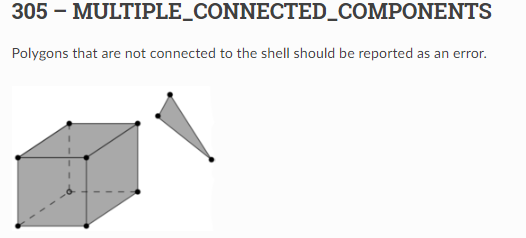

**This particular area contains buildings with courtyards and roads with traffic circles. The courtyards and interior of the traffic circles** (polygons) **are islands of terrain disconnected from the *larger* TINRelief** (shell); **thus the error.**

**As always; you are welcome to raise an issue. I depend on you to help me improve.**